In [1]:
import matplotlib.pyplot as plt
import numpy as np
from astroML.datasets import generate_mu_z
from sklearn.linear_model import LinearRegression
#from astroML.linear_model import PolynomialRegression

## Time to get your hands dirty! Supernova distances and redshifts (part 1)

Measuring the cosmological relationship between distance and redshift is at the heart of the entire field of cosmology and allowed, among other things, the discovery of dark energy! At high redshifts, this is done with Type Ia Supernova which are standard (or better, standardizable) candles.

This is a [Nobel prize](https://www.nobelprize.org/prizes/physics/2011/riess/facts/) plot by [Riess et al](https://iopscience.iop.org/article/10.1086/300499)

![Screen%20Shot%202022-05-01%20at%2010.48.48.png](attachment:Screen%20Shot%202022-05-01%20at%2010.48.48.png)

Let's recall the definition of magnitude and the distance modulus (ah! the astronomers...)

$$
\mu = m-M =  5 \log_{10}\left(\frac{d_L}{\rm pc}\right) - 5
$$

Here is the Hubble diagram for Type Ia supernovae (which are standard candels). The lines show the predictions for cosmologies with varying amounts of Ωm and ΩΛ. The observed points all lie above the line for a universe with zero Λ. The lower panel, with the slope caused by the inverse square law taken out, shows the difference between the predictions more clearly and shows why a model with ΩΛ > 0 is favored. 

####  Tasks

- First, explore fitting this data with the tecniques we have seen.
- Start from linear regression and polynomial regression
- For the case of  polynomial regression, just fit many of them for now.
- Let's bet based on intuition! Which fit is the best?
- In what cases are you underfitting the data?
- In what cases are you overfitting the data?
- Now split the data into training and validation sets
- Implement a cross-validation procedure
- Pick the best!
- Does it agree with our bets?

#### If you have time (or later at home...)

- Repeat with Basis Function Regression and Kernel Regression
- Explore what happens when you change the number of datapoints and plot the resulting learning curves.

(35.0, 50.0)

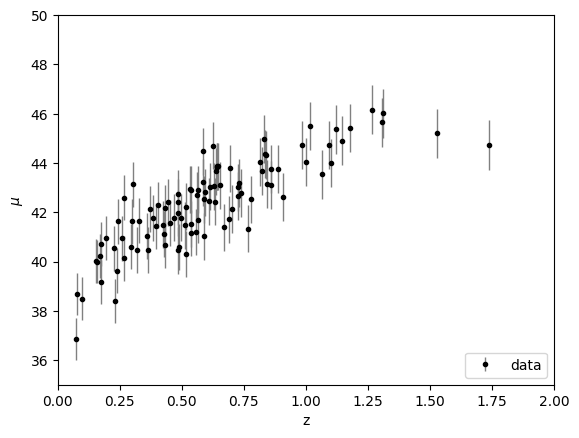

In [2]:
z_sample, mu_sample, dmu = generate_mu_z(100, random_state=1234)

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='lower right')
plt.xlim(0,2)
plt.ylim(35,50)

## linear

39.56505554722625 [4.64711848]


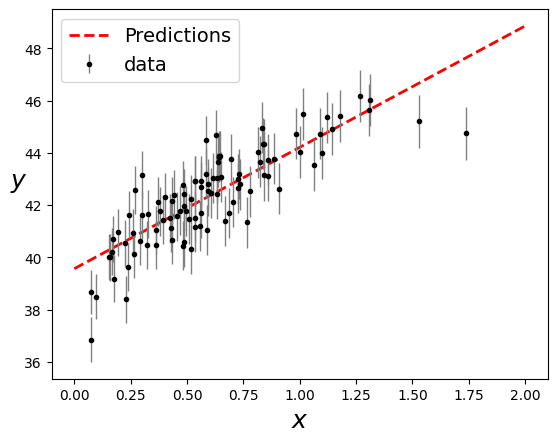

In [3]:
#X_grid = np.array([[0], [2]]) #like X_grid, but just with the endpoints
X_grid_1d = np.linspace(0,2, 100)
X_grid = X_grid_1d[:, np.newaxis]
X = z_sample[:, np.newaxis]
y = mu_sample
lin_reg = LinearRegression()
lin_reg.fit(X, y, sample_weight=1.0)

theta0 = lin_reg.intercept_
theta1 = lin_reg.coef_

print(theta0, theta1)
y_pred2 = lin_reg.predict(X_grid)


y_pred = theta0 + theta1*X_grid  # Complete 

plt.plot(X_grid, y_pred, "r--", linewidth=2, label="Predictions")
plt.errorbar(X, y, dmu, fmt='.k', ecolor='gray', lw=1,label='data')

plt.xlabel("$x$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=14)
plt.show()


# polynomial

In [4]:
# Typical call
from astroML.linear_model import PolynomialRegression


degree = 3
model = PolynomialRegression(degree) # fit 3rd degree polynomial
model.fit(X, y)

y_pred = model.predict(X_grid)
n_constraints = degree + 1

#print(X_grid,y_pred)
print(model.coef_)



plt.plot(X_grid, y_pred, "r--", linewidth=2, label="Predictions")
plt.errorbar(X, y, dmu, fmt='.k', ecolor='gray', lw=1,label='data')

plt.xlabel("$x$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=14)
plt.show()

/home/malvi/venv/lib/python3.11/site-packages/theano/scalar/basic.py:2412: FutureWarning: In the future `np.bool` will be defined as the corresponding NumPy scalar.
  self.ctor = getattr(np, o_type.dtype)


AttributeError: module 'numpy' has no attribute 'bool'.
`np.bool` was a deprecated alias for the builtin `bool`. To avoid this error in existing code, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

Should do cross validation etc...


# Lecture 18

In [5]:
from sklearn.gaussian_process import GaussianProcessRegressor, kernels
from scipy.optimize import fmin_cobyla

First let's fit our supernova synthetic data from last time using GPR.

- The key ingredient in getting a good GPR fit is the choice of the kernel and its parameters.
- Check out what's available in the `kernels` submodule of [sklearn.gaussian_process](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.gaussian_process)
- *Hint*. Radial-basis function kernel (aka squared-exponential kernel) is a standard choice in the GPR world.
- Plot the expectation value of the fit as well as the resulting 1-$\sigma$ and 2-$\sigma$ contours.
- Interpret the results.

*Note*. We have time constraints, so feel free to tweak the hyperparameters manually while in class. But, of course, a publication-quality result will require a cross-validation analysis. (Do this at home before the exam?)We now have a suite of **data-driven** predictive models for our supernova dataset (from polynomials to GPR). That is: we can faithfully predict how a future redshift/distance measurement will look like given the current sample.

This is already great and these kind of tools are immensely useful in a variety of contexts (also involving a lot of money: suppose you want to predict how much a give financial asset will perform on tomorrow's stock market... You  might not really care about expressing the underlying financial model in simple terms, as long as your investments are profitable).

For the case of supernovae, however, we have do have physical theory which is $\Lambda$CDM. We can do a **parametric** fit (and hopehully by now the difference between "parametric" and "data driven" fit is clear in your head)

- First, refresh your cosmology and write down the predicted relationship between the distance module $\mu$ and the redshift $\sigma$. *Hint* I always forget these things, my to-go reference is [Hogg (2010)](https://arxiv.org/abs/astro-ph/9905116). I got:

$$\mu = 5 \log \left( \frac{c/H_0} {10 {\rm pc}}(1+z)\int_0^z \frac{dz'}{\sqrt{\Omega_m (1+z^3)+\Omega_\Lambda}} \right) $$


- Assuming a flat Universe,  we have a parametric non-linear model for $\mu(z)$ that depends on two parameters, the Hubble constant $H_0$ and the matter content of the Universe $\Omega_m$
- It's a very non-linear model. Fit it to the data (however you want to do it, are you frequentist or Bayesian after all?).
- What are the measured value of $H_0$ and $\Omega_m$. Are they correlated?
- How would a model without dark energy (i.e. $\Omega_m=1$) perform? Do these data contain evidence of dark energy? (Hint: this is a model selection problem!)

The European Space Agency is considering new cosmology-related space mission. They ask you to figure out what science you can do with 10 times more measurement compared to what you have right now. That is: you want to clone your data. We've seen this earlier in the class, but now we can do much much better.
- Think about the pdf of these data in $z$.
- Using both the GPR fit and your latest $\Lambda$CDM fit, generate a set of $\mu$ measurements that respects the statistical properties of the data you were given. 



(35.0, 50.0)

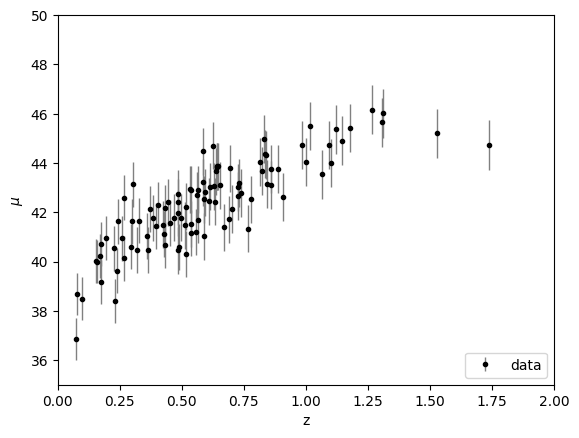

In [6]:
plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='lower right')
plt.xlim(0,2)
plt.ylim(35,50)

kernel_1 = kernels.RBF(length_scale=1.0, length_scale_bounds=(1e-05, 100000.0))

In [16]:
# draw samples from the unconstrained covariance
np.random.seed(1)
x = np.linspace(0, 2, 100) #This sets the number of Gaussians
h = 1.0  #This is the Bandwidth

kernel_1 = kernels.RBF()
gp = GaussianProcessRegressor(kernel=kernel_1, alpha=dmu ** 2,normalize_y = True, random_state=0)
gp.fit(z_sample[:, None], mu_sample)
f, f_err = gp.predict(x[:, None], return_std=True)


/tmp/ipykernel_440341/1827599412.py:6: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string ".k" (-> color='k'). The keyword argument will take precedence.
  plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ms=6, c = "navy")


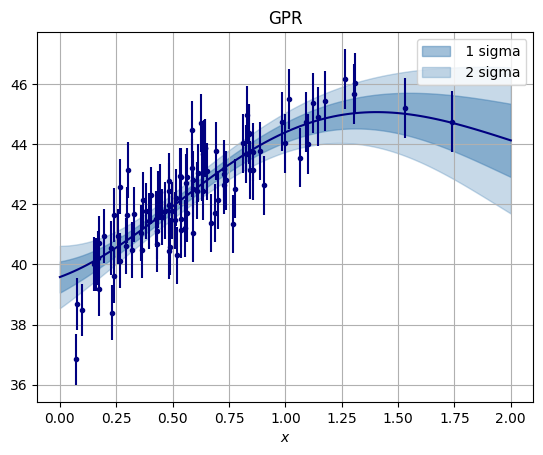

In [27]:
plt.plot(x, f, '-', color='navy')

plt.fill_between(x, f - 1 * f_err, f + 1 * f_err, color='steelblue', alpha=0.5, label = " 1 sigma")
plt.fill_between(x, f - 2 * f_err, f + 2 * f_err, color='steelblue', alpha=0.3, label = " 2 sigma")

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ms=6, c = "navy")

#plt.plot(x, np.cos(x), ':k')
plt.xlabel('$x$')
plt.title("GPR")
plt.legend()
plt.grid()